In [1]:
import os 
import matplotlib.pyplot as plot
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.collections import PatchCollection
import seaborn as sns
import pandas as pd
import csv 
import numpy as np 
import skimage.feature as si

In [2]:
def get_data(file_name):
    with open(file_name, 'r') as array3D:
        content = array3D.read()
    
    # Sort data into two variables , one with the image data (scan_array)
    # and another with the meta data for the image. 
    scan_array = []
    meta_data = []

    lines = content.splitlines()#[6:]
    for line in lines:
        columns = line.split('\t')
        if len(columns) < 20:
            meta_data.append(columns)
            continue 
        scan_array.append(columns[0:len(columns)-1]) 

    # convert the scan_array list into a float array. 
    image_array = np.array(scan_array, dtype = np.float)
    
    max_fluorescence = np.max(image_array)
    
    return(image_array, meta_data, max_fluorescence)
    #background = np.mean(image_data)
    #print(background)

In [3]:
def xy_scales(meta_data):
    # Extract the XYZ scaling information from the meta_data list. 
    xy = meta_data[10]
    XYscaling = np.array(xy[0:len(xy)-1], dtype = np.float)
    #find the maximum scan length
    scan_maxima = [XYscaling[2]-XYscaling[1], 
                   XYscaling[5]- XYscaling[4]]
    
    voxel_size = np.empty([len(scan_maxima)])
    #find the size of each voxel/pixel
    for i in range(len(scan_maxima)):
        voxel_size[i] = scan_maxima[i]/int(XYscaling[i*3+3]) 

    # Create the pixle arrays for both the x and y range.
    x_scan = np.linspace(0, scan_maxima[0], int(XYscaling[3]))
    y_scan = np.linspace(0, scan_maxima[1], int(XYscaling[6]))
    
    return(x_scan, y_scan, voxel_size)

In [4]:
def two_d_meshgrid(x_scan, y_scan, image_data):
    # create a mesh grid fo the heatmap
    X, Y = np.meshgrid(x_scan, y_scan)
    # Put all the data into a pandas data frame. 
    data_array = pd.DataFrame({'x':X.ravel(), 'y':Y.ravel(), 'Counts':image_data.ravel()})
    #the data_array needs to be pivoted to display properly in the heatmap.
    image_frame = data_array.pivot('y', 'x','Counts')
    return(image_frame)

In [5]:
def get_tick_labels(scan_data):
    # Get the values for tick marks incase they are needed for plotting. 
    ticks = [] 
    indicies = []
    for i in range(len(scan_data)):
        if i/20 == np.floor(i/20):
            ticks.append(scan_data[i])
            indicies.append(i)
    
    return(ticks)

In [6]:
def get_scalebar(x_scan, voxel_size, ax):
    # defines the length of the scale bar and its caption.
    scale_bar_pixel_length = 0.1* len(x_scan)
    scale_bar_si_length = round(scale_bar_pixel_length*voxel_size, 1)
    
    #Generate scale bar
    bar = AnchoredSizeBar(ax.transData, scale_bar_pixel_length, 
                          str(scale_bar_si_length) + r'$\mu$m', 
                          4, size_vertical = 1, pad = 0.25)
   # Add scalebar to image
    ax.add_artist(bar)
    
    return(int(scale_bar_pixel_length), scale_bar_si_length)

In [7]:
def find_NDs(image_frame, min_dis, num_NDs):
    # Uses the skimage package to locate the local maxima of an image. 
    nd_locations = si.peak_local_max(image_frame, min_distance = min_dis, exclude_border = True, num_peaks = num_NDs)
    return(nd_locations)

In [8]:
def plot_heatmap(image_frame, xticks, yticks, max_fluorescence):
    ## This section produces a seaborn heatmap with no x and y labels or tick marks.

    #generate a subpolt.
    fig, ax = plot.subplots()
    # change the plot text sizes. 
    sns.set(rc={'figure.figsize':(12,8)}, font_scale = 1.5)
    # generate the heatmap 
    
    #Code for making a cube-helix colour map
    #cmap = sns.cubehelix_palette(start = 0.5, rot = .3, reverse = True, dark=0.3, light=1, as_cmap=True)
    cmap = 'viridis'
    
    heat_map = sns.heatmap(image_frame, vmin =0 , vmax = 0.90*max_fluorescence,
                           cbar_kws = {'label':'\n Counts (per int time)'},
                           xticklabels = 20, yticklabels = 20, cmap = cmap)
    # set the tick marks for the heat map.
    ax.set_yticklabels(yticks, rotation = 0)
    ax.set_xticklabels(xticks, rotation = 0)
    # set the x and y labels. 
    ax.set_ylabel('y ' + r'($\mu$m)')
    ax.set_xlabel('x ' + r'($\mu$m)')

    return(fig, ax)

In [9]:
def plot_roi(nd_locs, ax, color, radius):
    ## I have grabbed/ammended this function from: 
    # https://stackoverflow.com/questions/51672327/skimage-peak-local-max-finds-multiple-spots-in-close-proximity-due-to-image-impu
    # I am sure that this isn't an issue for copyright/IP or anything, but better to be safe. 

    # This function plots all of the regions of interest onto the heatmap. 
    patches = []
    a = 1
    for nd in nd_locs:
        y, x = nd
        c = plot.Circle((x, y), radius)
        ax.annotate('ND ' + str(a), xy = [x-2, y + 10], color = color)
        patches.append(c)
        a += 1
        
    ax.add_collection(PatchCollection(patches, facecolors = "None", edgecolors = color, alpha = 0.5, linewidths = 3))


In [10]:
def draw_rectangle(voxel_size, ax):
    # plots a rectangle on the graph. 
    rectangle = plot.Rectangle((15.5/voxel_size[0], 15.5/voxel_size[1]),
                           10/voxel_size[0], 10/voxel_size[1], 
                           fill = False, ec = 'Yellow', linewidth = 2)
    
    plot.gca().add_patch(rectangle)
    return(ax)

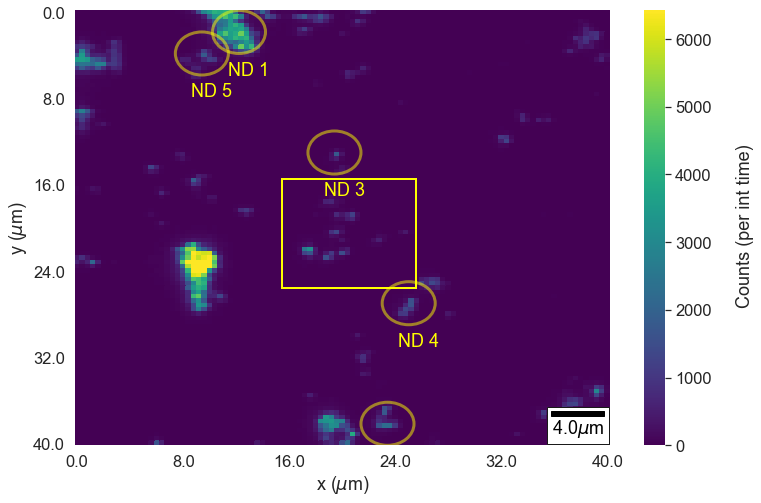

In [12]:
# Get the location of the file of interest in the directory. 
folder_name = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\Thermometry\\'
date = '20200124'
file_name = folder_name + date + '\\' + date + '_01.dat'

# Sort the image data and the meta data into different variables, extract the max fluorescence value. 
image_array, meta_data, max_fluorescence = get_data(file_name)
# Generate arrays describing the 2D scans used to create the image. 
x_scan, y_scan, voxel_size = xy_scales(meta_data)
# Store scan and image data into a pandas data frame. 
image_frame = two_d_meshgrid(x_scan, y_scan, image_array)

# Locate the nanodiamonds within an image. 
#find_NDs(image_array, Minimum distance to check for another maxima, number of NDs to search for.)
nd_locs = find_NDs(image_array, 3, 12)

# Get labels for tick marks.
x_ticks = get_tick_labels(x_scan)
y_ticks = get_tick_labels(y_scan)

#Plot the heatmap
fig, ax = plot_heatmap(image_frame, x_ticks, y_ticks, max_fluorescence)

# Generate and plot the scale bar.
scale_bar_pix, scale_bar_si = get_scalebar(x_scan, voxel_size[0], ax)

#Select the nanodiamonds in plot used for experiment
NDS = [1, 5, 8, 10, 9]
#Plot the nanodiamonds as regions of interest. 
plot_roi(nd_locs[NDS, :], ax, 'yellow', radius = 5)


draw_rectangle(voxel_size, ax)


## Could add in another funtion here that will ignore/not plot any ROI's that are over 0.8*max_fluorescence
## This would allow us to identify the smaller nanodiamonds in a large image, excluding the brighter clusters. 
## Not really efficient though as the peak_local_max function will have already run with the maximum values present. 
## It would be nice to modify the code to have a cut off fluorescence value, where anything over x counts per int time
## is automatically ingnored. 

In [36]:
fig.savefig('C:\\Users\\Ryan\\Desktop\\' + date + '_NDs_map1' + '.pdf')